# FACS Analysis

This Jupyter notebook walks you through the basic steps of analyzing Mass-Titr FACS results. For high-throughput binding experiments, the `highThroughputScripts` pipeline is available on [GitHub](https://github.com/KeatingLab/highThroughputScripts/tree/vs_optimization).

To complete the analysis, run all cells in order one-by-one unless otherwise specified, filling in or changing input values as needed. (Hint: Use `Shift+Enter` to run a cell then advance to the next one.) To export a plot, you may want to change the DPI in the `plt.figure` command, i.e. `plt.figure(..., dpi=160)`.

**Requirements**: This notebook requires Python 2, and the following modules:

* `FlowCytometryTools` (install using `pip install flowcytometrytools`)
* `lmfit`
* `ipywidgets`, version 7.2 or later (upgrade if necessary)
* The script `facs_utils.py` must be in the same directory as this notebook.

After installing these modules, be sure to restart the notebook kernel to make sure the modules are available.

*Written by*: Venkatesh Sivaraman, February 2019, adapted from scripts by Dustin Whitney and Theresa Hwang

In [ ]:
### Experiment metadata
# Name:
# Date:
# Info:

In [19]:
%load_ext autoreload
%autoreload 2
%pylab inline
import os
from FlowCytometryTools import FCMeasurement
from FlowCytometryTools import ThresholdGate, PolyGate
import pandas as pd 
from lmfit import Model, Parameters, Minimizer
import facs_utils as facs
from collections import OrderedDict
from FlowCytometryTools.core.transforms import hlog

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [20]:
# Dictionary that contains gating information (rerun this cell to reset interactive gate info)
GATE_RESULTS = {}

# Boundary value for hyperlog transformation
HYPERLOG_B = 100.0

## Step 0. Preliminaries

First we need to provide some information about the experiment, and point the script to where the data is located.

In [21]:
# Path to directory containing .fcs files
DATA_PATH = "../../../Avi_data/Bacteria PE APC 031221/"

Define and label your titrations here, along with the concentrations at which the experiment was performed. 

Because there are many different methods of plate organization and file naming, you must use the `make_titration` function to tell the script which fcs files to draw data from for each titration. The function takes as parameters the **specimen number**, the **letter code**, and the **number code** for each stop. Each parameter can also be a list, range, or string whose length is the number of concentrations. *Remember that the `range` function's upper bound is non-inclusive, so `range(1, 13)` produces the values [1,2,...,12].*

**Examples:**
* For the command `make_titration(1, 'ABCDEFGH', 1)`, the following wells from Specimen 1 will be used: A1, B1, C1, D1, E1, F1, G1, H1.
* For the command `make_titration(2, 'B', range(1, 7)`, wells B1-B6 prefixed with Specimen 2 will be used.

In [22]:
CONCENTRATIONS = np.array([15, 7.5, 3.75, 1.875, 0.9375, 0.46875, 0.234375, 0])

TITRATIONS = [
    # The behavior implemented here is to divide each letter code into two sets (1-6 and 7-12),
    # each of which constitutes one titration. Adjust this as needed based on your 
    # experimental setup.
    facs.make_titration(3, 'B', range(1, 9)),
    facs.make_titration(4, 'C', range(1, 9)),
    facs.make_titration(5, 'D', range(1, 9)),
]

# Add a descriptive label here for each titration you listed above (e.g. indicate the peptide being tested).
LABELS = [
    "Mena-ActA", "Mena-empty", "Mena-pCare"
]

assert all([len(t) == len(CONCENTRATIONS) for t in TITRATIONS]), "All titrations must have same number of concentrations as CONCENTRATIONS list"
assert len(LABELS) == len(TITRATIONS), "Need {} labels to match titrations list, found {}".format(len(TITRATIONS), len(LABELS))

In [70]:
# Defining axes for various types of gates
scatter_axes_1 = ["FSC-H", "SSC-H"]
scatter_axes_2 = ["SSC-H", "SSC-W"]
fluor_axes = ["Alexa Fluor 680-A", "PE-A"]

# These axes can be hyperlog-transformed if specified
transformable_axes = ["FSC-H", "SSC-H", "SSC-W", "Alexa Fluor 680-A", "PE-A"]

# Binding axis
binding_axis = "PE-A"

In [24]:
# Utility functions to get sample paths and data

def get_titration_files(titration):
    """Returns the list of fcs files in DATA_PATH corresponding to the given list of concentration stops."""
    return [get_sample_path(*stop) for stop in titration]

def get_sample_path(specimen_number, letter, sample_number):
    """Gets the path for the sample with the given specimen number, letter code, and sample number for the letter code."""
    prefix = 'Specimen_' + str(specimen_number).zfill(3) + '_' + letter + str(sample_number) + '_'
    
    paths = [os.path.join(DATA_PATH, path) for path in os.listdir(DATA_PATH) if path.startswith(prefix)]
    assert len(paths) > 0, "No path found for ({}, {}, {})".format(specimen_number, letter, sample_number)
    assert len(paths) == 1, "Multiple paths satisfy sample path condition"
    return paths[0]

   
def get_sample(path, id_name, transform=False):
    """Gets a measurement from the given fcs file path, transforming its scatter values using a hyperlog 
    transformation if specified."""
    sample = FCMeasurement(ID=id_name, datafile=path)
    if transform:
        return facs.transform_sample(sample, HYPERLOG_B=HYPERLOG_B)# WARNING HYPERLOG_B is global
    return sample

## Step 1. Forward-Scatter and Side-Scatter Gating

In [25]:
# Get sample files to test the scatter gates on

test_files = get_titration_files(TITRATIONS[0])
test_samples = [get_sample(path, "Test", transform=True) for path in test_files]

test_file = test_files[0]
test_sample = test_samples[0]

### 1(a). Drawing Gates
**NOTE**: The following two cells utilize the interactive gate drawing tool, the first to draw a gate on the FSC-H/SSC-H plot, and the second to gate the SSC-H/SSC-W plot. If no polygon gate is desired, simply skip over the cell without running it. Alternatively, if you already know the vertices for the desired gates, skip to section 1(b) and replace the value of either `gate_vertices_1` or `gate_vertices_2` with the list of coordinates you want.

In [8]:
# Choose the number of vertices to use on the gate.
num_points = 3

# Opens the interactive gate drawing tool.
# Use test_samples to plot all 'A' samples together, or test_sample to plot just the first sample (may be faster).
facs.vertex_control(test_samples, scatter_axes_1, num_points, GATE_RESULTS, 'scatter_gate_1', log=False)

Drag one of the sliders to make the plot visible.


In [14]:
# Choose the number of vertices to use on the second gate.
num_points = 4

# Opens the interactive gate drawing tool.
# Use test_samples to plot all 'A' samples together, or test_sample to plot just the first sample (may be faster).
facs.vertex_control(test_samples, scatter_axes_2, num_points, GATE_RESULTS, 'scatter_gate_2', log=False)

Drag one of the sliders to make the plot visible.


### 1(b). Defining the Gates

In [26]:
# Creates the main scatter gate using the interactive results. Set the gate_vertices variables to None 
# if no polygon gate is desired.
# gate_vertices_1 = GATE_RESULTS.get('scatter_gate_1', None)
gate_vertices_1 = [(8270.0, 9125.0), (6295.0, 8875.0), (7670.0, 8625.0), (9890.0, 8640.0), (9950.0, 9095.0)]
# gate_vertices_2 = GATE_RESULTS.get('scatter_gate_2', None)
gate_vertices_2 = [(9030.0, 7060.0), (8755.0, 7385.0), (8705.0, 4340.0), (9060.0, 4175.0)]
scatter_gates = []

if gate_vertices_1 is not None:
    scatter_gates.append(PolyGate(gate_vertices_1, scatter_axes_1, region='in', name='scatter_gate_1'))
    print("Gate 1 created with vertices: {}".format([tuple(row) for row in gate_vertices_1]))
if gate_vertices_2 is not None:
    scatter_gates.append(PolyGate(gate_vertices_2, scatter_axes_2, region='in', name='scatter_gate_2'))
    print("Gate 2 created with vertices: {}".format([tuple(row) for row in gate_vertices_2]))
    
if gate_vertices_1 is None and gate_vertices_2 is None:
    print("No polygon gates will be used.")

# Optionally, create some threshold gates to further filter the data.
scatter_threshold_gates = [
    # ThresholdGate(0, 'FSC-H', region='above'),
    # ThresholdGate(9000, 'SSC-H', region='below'),
    # ThresholdGate(300, 'SSC-H', region='above')
]

gates_to_show1 = [x for x in scatter_gates + scatter_threshold_gates if all([c in scatter_axes_1 for c in x.channels])]
gates_to_show2 = [x for x in scatter_gates + scatter_threshold_gates if all([c in scatter_axes_2 for c in x.channels])]


def gate_by_scatter(sample):
    """Gates the given FCMeasurement using the scatter_gate and the list of scatter_threshold_gates. 
    Returns the new gated sample."""
    tsample = sample
    for gate in scatter_gates + scatter_threshold_gates:
        tsample = tsample.gate(gate)
    return tsample

Gate 1 created with vertices: [(8270.0, 9125.0), (6295.0, 8875.0), (7670.0, 8625.0), (9890.0, 8640.0), (9950.0, 9095.0)]
Gate 2 created with vertices: [(9030.0, 7060.0), (8755.0, 7385.0), (8705.0, 4340.0), (9060.0, 4175.0)]


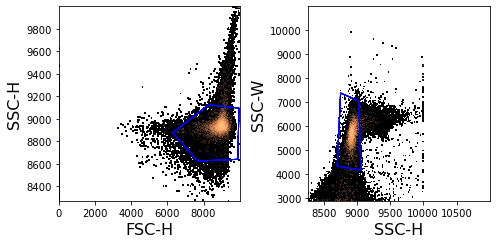

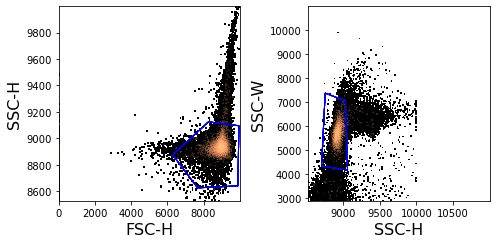

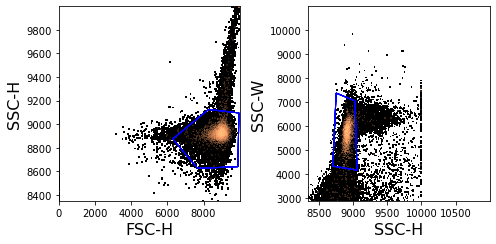

In [44]:
# ==============================================================================
# // check gates against all plots (overlaid) within a titration 
# ==============================================================================

def gate_check(sample_list, scatter_axis, same_lims=True, gate = None, ax=None):
#     plt.figure()
    maxes = []
    for sample in sample_list:
        sample.plot(scatter_axis, gates=gate, ax=ax)
        maxes.append(sample[scatter_axis].max().max())
    if same_lims:
        ax_lim = max(maxes)*1.1
        plt.xlim(xmax=ax_lim)
        plt.ylim(ymax=ax_lim)
#     plt.show()


for titration in TITRATIONS:
    test_files = get_titration_files(titration)
    test_samples = [get_sample(path, "Test", transform=True) for path in test_files]
    fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=[7,3.5])
    gate_check(test_samples, scatter_axes_1, gate = gates_to_show1, ax = ax1)
    gate_check(test_samples, scatter_axes_2, gate = gates_to_show2, ax = ax2)
    plt.tight_layout()

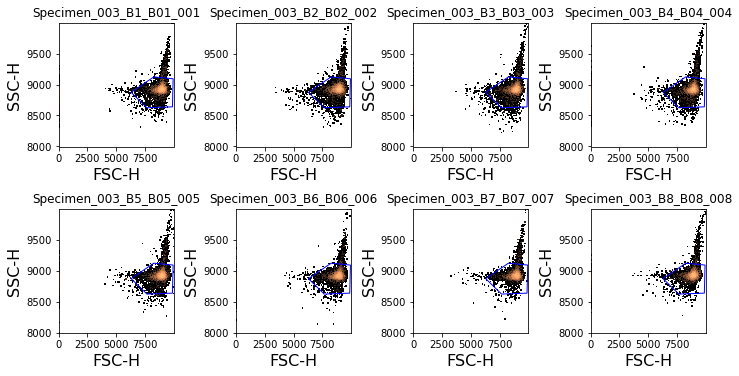

In [41]:
facs.multi_plots_files(get_titration_files(TITRATIONS[0]), axes=scatter_axes_1, log=False, gates = gates_to_show1, transform=True)

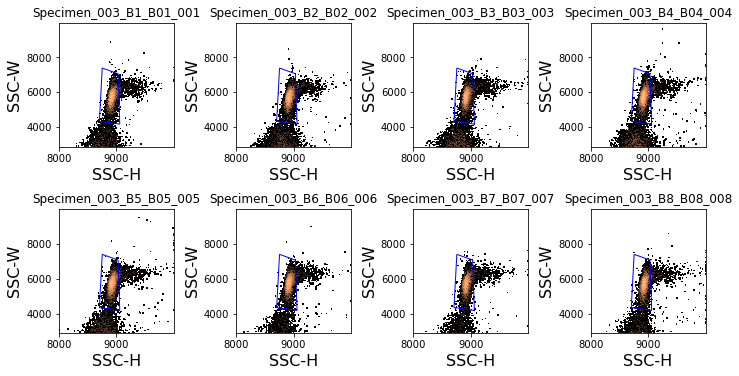

In [42]:
facs.multi_plots_files(get_titration_files(TITRATIONS[0]), axes=scatter_axes_2, log=False, gates = gates_to_show2, transform=True)

## Step 2. Fluorescence Gating

In [48]:
def overlay_plt(sample_list, scatter_axis, same_lims=True, gate = None, ax=None):
    maxes = []
    for sample in sample_list:
        sample.plot(scatter_axis, gates=gate, ax=ax, kind='scatter', color='r', s=1)
        maxes.append(sample[scatter_axis].max().max())
    if same_lims:
        ax_lim = max(maxes)*1.1
        plt.xlim(xmax=ax_lim)
        plt.ylim(ymax=ax_lim)

In [31]:
# Gate the test samples from above
fluor_samples = [gate_by_scatter(samp) for samp in test_samples]
fluor_sample = fluor_samples[0]

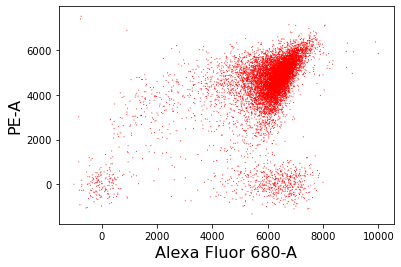

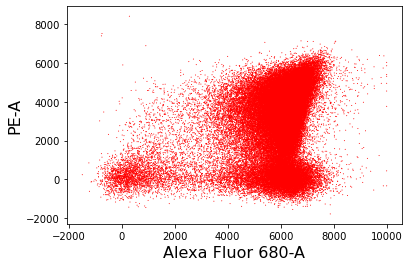

In [51]:
# Take a look at the first sample, and all the samples
plt.figure()
fluor_sample.plot(fluor_axes, ax=plt.gca(), kind='scatter', color='r', s=1);
plt.figure()
overlay_plt(fluor_samples, fluor_axes, same_lims=False)

### Defining gates
I am choosing to do threshold gates for the fluorescence signals. You can look at Venkat's script if you would like to use polygon gates

In [52]:
# Enter the Alexa Fluor 680-A threshold. We will be keeping only data that is above threshold value
EXPRESSION_THRESHOLD = 2000

In [57]:
# Create some threshold gates to further filter the data.
fluor_threshold_gates = [
    # ThresholdGate(, 'PE-A', region = 'above'),
    ThresholdGate(EXPRESSION_THRESHOLD, 'Alexa Fluor 680-A', region = 'above'),
]

def gate_by_fluorescence(sample):
    """Gates the given FCMeasurement using the fluor_gate and the list of fluor_threshold_gates. 
    Returns the new gated sample."""
    tsample = sample
    for gate in fluor_threshold_gates:
        tsample = tsample.gate(gate)
    return tsample

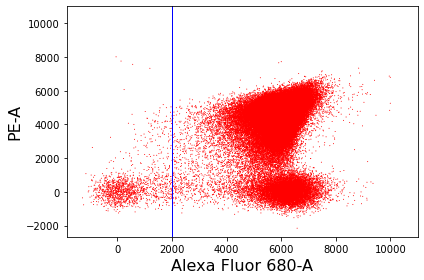

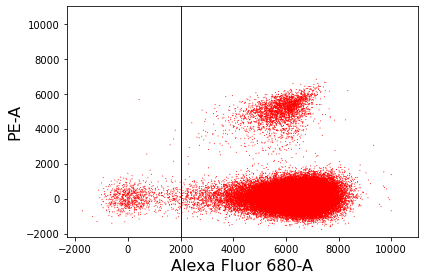

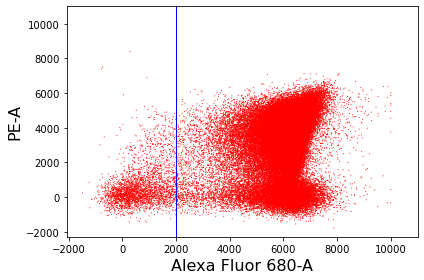

In [66]:
gates_to_show = fluor_threshold_gates
for titration in TITRATIONS:
    test_files = get_titration_files(titration)
    test_samples = [get_sample(path, "Test", transform=True) for path in test_files]
    fluor_samples = [gate_by_scatter(samp) for samp in test_samples]
    plt.figure()
    overlay_plt(fluor_samples, fluor_axes, gate = gates_to_show)
    plt.tight_layout()

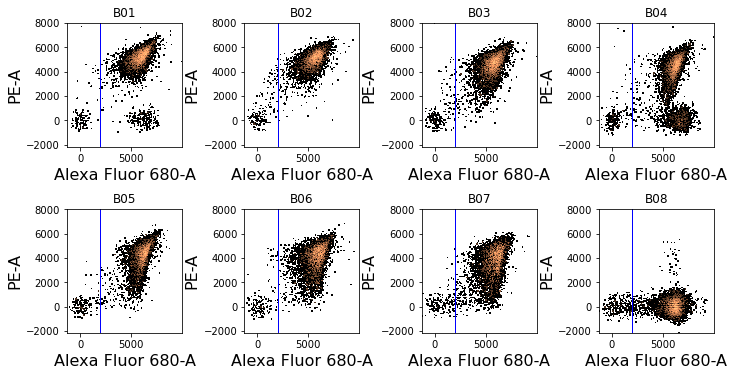

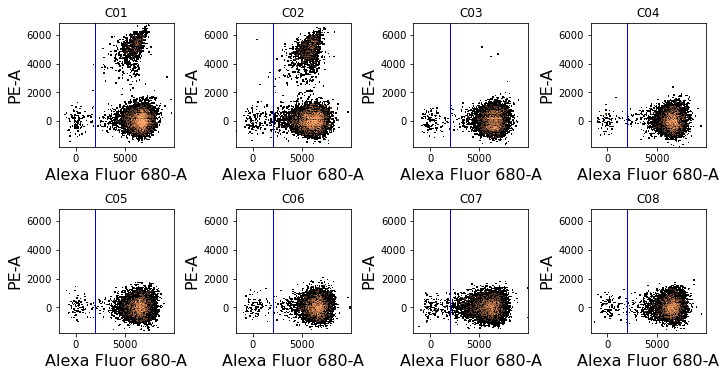

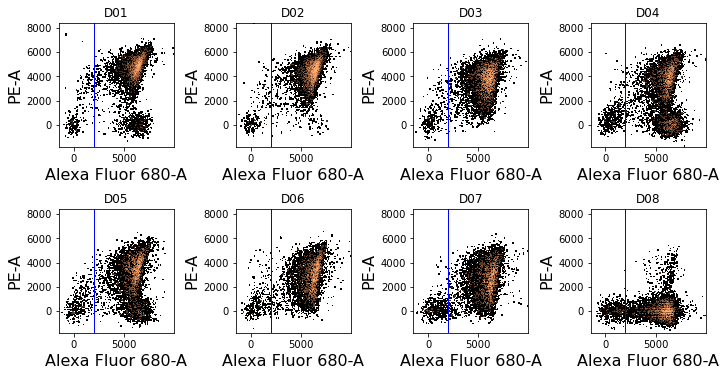

In [67]:
gates_to_show = fluor_threshold_gates
for titration in TITRATIONS:
    test_files = get_titration_files(titration)
    test_samples = [get_sample(path, "Test", transform=True) for path in test_files]
    fluor_samples = [gate_by_scatter(samp) for samp in test_samples]
    facs.multi_plots_sample(fluor_samples, axes=fluor_axes, log=False, gates = gates_to_show)

## Step 3. $K_d$ Estimation

Up until now we have only been working with a small subset of the data - now, we will perform the analysis on all samples. 

**A note on transformations:** All of the gates we have created are in hyperlog-space, so this script is careful to apply any gates in that space. The best practice for fitting, however, is usually to perform the fit on linear (un-transformed) medians. If the `linear_medians` variable below is set to `True`, the median of the un-transformed data will be used (still gated in log space); otherwise, the median of the transformed data will be used.

In [68]:
# If this is set to True, we will use the untransformed data to get the medians; 
# otherwise, we use the log-transformed data
linear_medians = True

## TODO - change to one of the pandas methods I used in `../04-2021-03-02-single_clone_titration-3/01.ipynb`

In [71]:
# Get the medians of every gated sample
medians = np.zeros((len(TITRATIONS), len(CONCENTRATIONS)))

for i, titration in enumerate(TITRATIONS):
    for j, sample_info in enumerate(titration):
        # Get the path for this sample
        path = get_sample_path(*sample_info)
        id_name = os.path.splitext(os.path.basename(path))[0]

        # Load the sample and gate it
        sample = get_sample(path, id_name, transform=False)
        tsample = facs.transform_sample(sample, HYPERLOG_B = HYPERLOG_B)
        filtered_tsample = gate_by_fluorescence(gate_by_scatter(tsample))
        filtered_sample_data = sample.get_data().loc[filtered_tsample.get_data().index]

        # Compute median of binding axis values
        if linear_medians:
            medians[i, j] = filtered_sample_data[binding_axis].median()
        else:
            medians[i, j] = filtered_tsample.data[binding_axis].median()

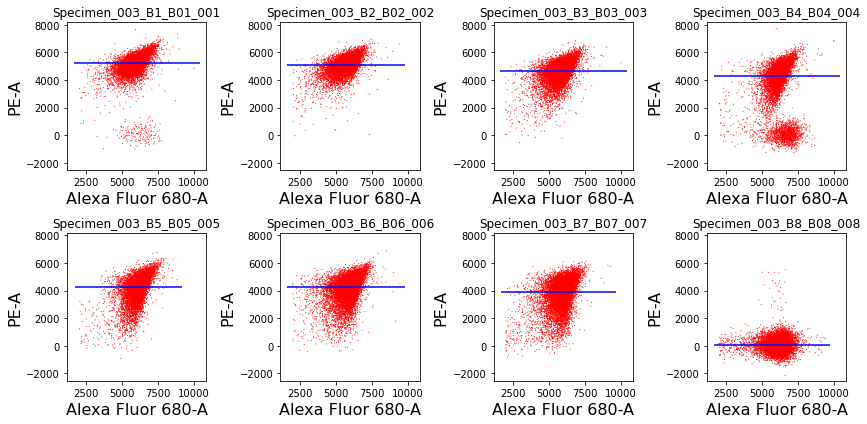

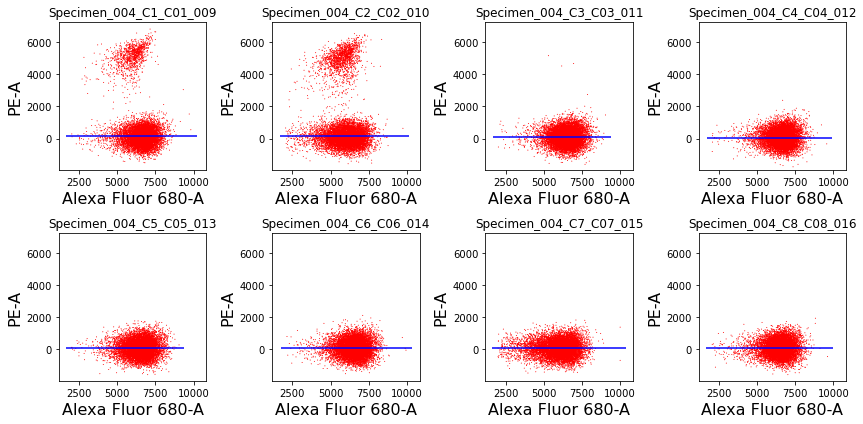

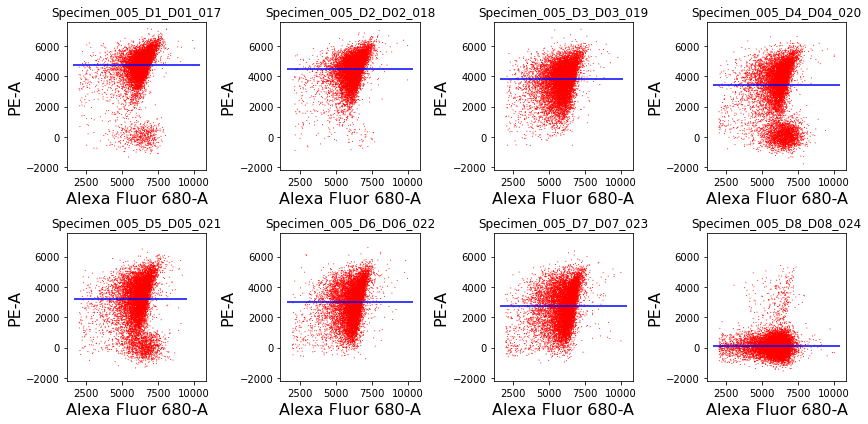

In [76]:
# Plot the medians
# this is really messy but it wasn't worth the time investment to transfer what was there
# titration_to_plot = 1
for c,titration in enumerate(TITRATIONS):
    plt.figure(figsize=(12, 6))
    previous_axes = []
    xmin, xmax, ymin, ymax = 1e9, -1e9, 1e9, -1e9
    for sample_num, sample_info in enumerate(titration):
        # Get the path for this sample
        path = get_sample_path(*sample_info)
        id_name = os.path.splitext(os.path.basename(path))[0]
        median = medians[c, sample_num]

        # Load the sample and gate it
        sample = get_sample(path, id_name, transform=True)
        filtered_sample = gate_by_fluorescence(gate_by_scatter(sample))

        # Plot
        plt.subplot(2, int(ceil(len(CONCENTRATIONS) / 2.0)), sample_num + 1)
        filtered_sample.plot(fluor_axes, ax=plt.gca(), kind='scatter', color='r', s=1)
        # The median should be hlog-transformed for display if it's on a linear scale
        plt.hlines(hlog(median, b=HYPERLOG_B) if linear_medians else median, *plt.xlim(), color='b')
        plt.title(id_name)

        # Adjust limits
        previous_axes.append(plt.gca())
        new_xmin, new_xmax = plt.xlim()
        new_ymin, new_ymax = plt.ylim()
        xmin = min(new_xmin, xmin)
        xmax = max(new_xmax, xmax)
        ymin = min(new_ymin, ymin)
        ymax = max(new_ymax, ymax)
        for ax in previous_axes:
            ax.set_xlim(xmin, xmax)
            ax.set_ylim(ymin, ymax)    
    plt.tight_layout()


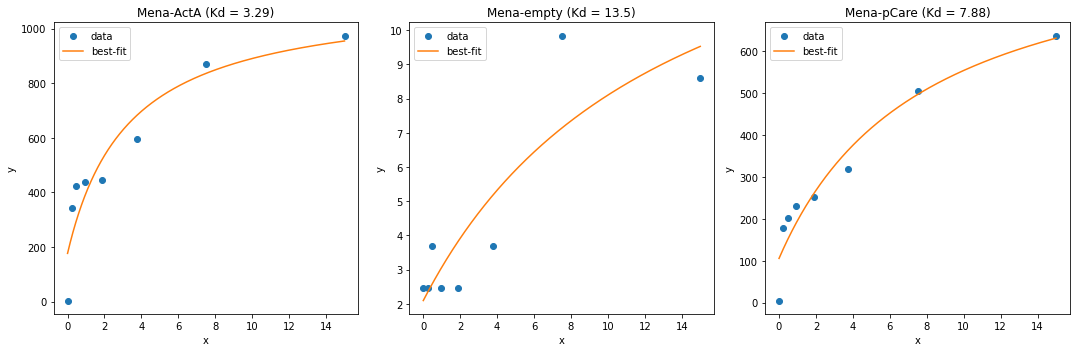

In [83]:
# Now we compute all the Kds. 
# Initial parameters:
init_lower = 0
init_upper = 4000
init_kd = 1
plot_fits = True

# List of dictionaries of fit results
fit_results = []

if plot_fits: plt.figure(figsize=(20, 5))
for i, (label, titration, dataset) in enumerate(zip(LABELS, TITRATIONS, medians)):

    if plot_fits:
        plt.subplot(int(ceil(len(TITRATIONS) / 4.0)), 4, i + 1)

    # Compute fit and save to results dictionary
    kd, sat, init, err, chisqr, r2 = facs.run_lmfit(CONCENTRATIONS, dataset, init_lower, init_upper, init_kd, plot_fits)
    result = [("label", label), 
              ("kd", kd), ("sat", sat), ("init", init),
              ("err", err), ("chisqr", chisqr), ("r2", r2)]
    for conc, val in zip(CONCENTRATIONS, dataset):
        result.append(("conc_{}".format(conc), val))
    fit_results.append(OrderedDict(result))

    if plot_fits:
        plt.title("{} (Kd = {:.3g})".format(label, kd))
            
if plot_fits:
    plt.tight_layout()
    plt.show()

In [84]:
# Build a dataframe from the results list
results_df = pd.DataFrame(fit_results)
results_df

,label,kd,sat,init,err,chisqr,r2,conc_15.0,conc_7.5,conc_3.75,conc_1.875,conc_0.9375,conc_0.46875,conc_0.234375,conc_0.0
0,Mena-ActA,3.292290,1125.404119,176.534424,2.487582,74681.273109,0.862976,974.160034,870.840027,594.090027,444.029999,439.110016,421.890015,343.170013,3.69
1,Mena-empty,13.497850,16.210123,2.097547,22.577146,13.867542,0.737327,8.610001,9.840000,3.690000,2.460000,2.460000,3.690000,2.460000,2.46
2,Mena-pCare,7.876207,907.297105,105.507368,5.542460,18974.671719,0.916857,637.140015,504.300018,318.570007,252.150009,230.010010,202.949997,177.119995,4.92


In [ ]:
# Choose an output path, and write out to CSV
out_path = "kd_list.csv"
results_df.to_csv(out_path, index=False)

That's all, folks!